In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Install Spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.3/spark-3.0.3-bin-hadoop3.2.tgz

# Unzip the Spark file to the current folder
!tar xf spark-3.0.3-bin-hadoop3.2.tgz

# Install findspark
!pip install -q findspark

# Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop3.2"

# Start a SparkSession
import findspark
findspark.init()

# Import SparkSession
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()


In [ ]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType, IntegerType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans, GaussianMixture
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline



In [ ]:
spark = SparkSession.builder \
    .appName("Healthcare Data Clustering") \
    .getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Data Analytic Lab/Stroke-data.csv')

<Axes: title={'center': 'Stroke: YES(1) vs NO(0)'}, xlabel='Output class', ylabel='Count'>

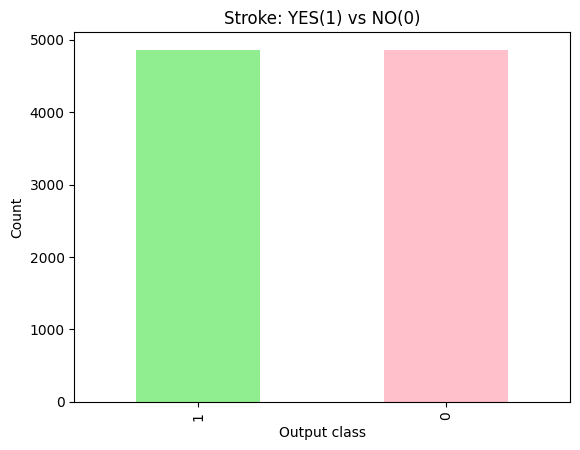

In [ ]:
df1.stroke.value_counts().plot.bar(
    color=['lightgreen', 'pink'],
    title="Stroke: YES(1) vs NO(0)",
    xlabel="Output class",
    ylabel="Count"
)

In [ ]:
# Load the dataset
df = spark.read.csv('/content/drive/MyDrive/Data Analytic Lab/Stroke-data.csv', header=True, inferSchema=True)

# Inspect the data types
df.printSchema()


root
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [ ]:
df.count()

9722

In [ ]:
from pyspark.sql.types import FloatType, IntegerType
from pyspark.sql.functions import col

# Handle missing values
df = df.na.fill({
    'bmi': df.select('bmi').dropna().agg({'bmi': 'mean'}).first()[0]
})

# Ensure all columns are converted to the correct type
df = df.withColumn("age", col("age").cast(IntegerType()))
df = df.withColumn("hypertension", col("hypertension").cast(IntegerType()))
df = df.withColumn("heart_disease", col("heart_disease").cast(IntegerType()))
df = df.withColumn("avg_glucose_level", col("avg_glucose_level").cast(IntegerType()))
df = df.withColumn("bmi", col("bmi").cast(IntegerType()))
df = df.withColumn("stroke", col("stroke").cast(IntegerType()))


In [ ]:
string_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in string_columns]

# Assemble features into a single vector
feature_columns = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'] + [col+"_index" for col in string_columns]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Scale features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

# Create a preprocessing pipeline
pipeline = Pipeline(stages=indexers + [assembler, scaler])
df_preprocessed = pipeline.fit(df).transform(df)

In [ ]:
from pyspark.ml.clustering import KMeans

# Apply K-Means Clustering
kmeans = KMeans(k=2, seed=1, featuresCol="scaledFeatures")
kmeans_model = kmeans.fit(df_preprocessed)
kmeans_predictions = kmeans_model.transform(df_preprocessed)


In [ ]:
from pyspark.ml.clustering import GaussianMixture

# Apply Gaussian Mixture Models
gmm = GaussianMixture(k=2, seed=1, featuresCol="scaledFeatures")
gmm_model = gmm.fit(df_preprocessed)
gmm_predictions = gmm_model.transform(df_preprocessed)


In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Initialize the evaluator for Silhouette Score
evaluator = ClusteringEvaluator(featuresCol="scaledFeatures", metricName="silhouette", distanceMeasure="squaredEuclidean")

# Evaluate K-Means
kmeans_silhouette = evaluator.evaluate(kmeans_predictions)
print(f"K-Means: Silhouette Score = {kmeans_silhouette}")

# Evaluate GMM
gmm_silhouette = evaluator.evaluate(gmm_predictions)
print(f"GMM: Silhouette Score = {gmm_silhouette}")


K-Means: Silhouette Score = 0.3382795036666148
GMM: Silhouette Score = 0.2961800376952987


In [ ]:
import numpy as np
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

def calculate_custom_metrics(predictions, feature_col, prediction_col):

    pdf = predictions.select(feature_col, prediction_col).toPandas()
    features = np.array(pdf[feature_col].tolist())
    labels = pdf[prediction_col].to_numpy()

    # Davies-Bouldin Index
    db_index = davies_bouldin_score(features, labels)

    # Calinski-Harabasz Index
    ch_index = calinski_harabasz_score(features, labels)

    return db_index, ch_index

# Evaluate K-Means
kmeans_db_index, kmeans_ch_index = calculate_custom_metrics(kmeans_predictions, "scaledFeatures", "prediction")
print(f"K-Means: Davies-Bouldin Index = {kmeans_db_index}, Calinski-Harabasz Index = {kmeans_ch_index}")

# Evaluate GMM
gmm_db_index, gmm_ch_index = calculate_custom_metrics(gmm_predictions, "scaledFeatures", "prediction")
print(f"GMM: Davies-Bouldin Index = {gmm_db_index}, Calinski-Harabasz Index = {gmm_ch_index}")


K-Means: Davies-Bouldin Index = 1.7410730151893694, Calinski-Harabasz Index = 1884.9099550925253
GMM: Davies-Bouldin Index = 2.3904100673002575, Calinski-Harabasz Index = 1360.6520579565884


In [ ]:
# Print the evaluation results
print(f"K-Means: Silhouette Score = {kmeans_silhouette}, Davies-Bouldin Index = {kmeans_db_index}, Calinski-Harabasz Index = {kmeans_ch_index}")

print(f"GMM: Silhouette Score = {gmm_silhouette}, Davies-Bouldin Index = {gmm_db_index}, Calinski-Harabasz Index = {gmm_ch_index}")


K-Means: Silhouette Score = 0.3382795036666148, Davies-Bouldin Index = 1.7410730151893694, Calinski-Harabasz Index = 1884.9099550925253
GMM: Silhouette Score = 0.2961800376952987, Davies-Bouldin Index = 2.3904100673002575, Calinski-Harabasz Index = 1360.6520579565884


In [ ]:
# Add cluster labels to the DataFrame
kmeans_predictions = kmeans_predictions.withColumnRenamed("prediction", "kmeans_cluster")

# Convert to Pandas for analysis
kmeans_df = kmeans_predictions.select(feature_columns + ["kmeans_cluster"]).toPandas()

# Analyze cluster characteristics
kmeans_summary = kmeans_df.groupby("kmeans_cluster").mean()
print("K-Means Cluster Characteristics:")
print(kmeans_summary)


K-Means Cluster Characteristics:
                      age  hypertension  heart_disease  avg_glucose_level  \
kmeans_cluster                                                              
0               62.551662      0.210914       0.150006         124.092720   
1               25.213172      0.031171       0.013072          93.774761   

                      bmi  gender_index  ever_married_index  work_type_index  \
kmeans_cluster                                                                 
0               29.999095      0.422216            0.043709         0.519721   
1               24.920563      0.420814            0.990447         1.437908   

                Residence_type_index  smoking_status_index  
kmeans_cluster                                              
0                           0.474848              1.232381  
1                           0.459025              0.950226  


In [ ]:
# Add cluster labels to the DataFrame
gmm_predictions = gmm_predictions.withColumnRenamed("prediction", "gmm_cluster")

# Convert to Pandas for analysis
gmm_df = gmm_predictions.select(feature_columns + ["gmm_cluster"]).toPandas()

# Analyze cluster characteristics
gmm_summary = gmm_df.groupby("gmm_cluster").mean()
print("GMM Cluster Characteristics:")
print(gmm_summary)


GMM Cluster Characteristics:
                   age  hypertension  heart_disease  avg_glucose_level  \
gmm_cluster                                                              
0            49.983229      0.000280       0.000000         108.794410   
1            68.652513      0.658746       0.462018         143.242306   

                   bmi  gender_index  ever_married_index  work_type_index  \
gmm_cluster                                                                 
0            28.526066      0.403354            0.274633         0.746751   
1            30.169848      0.473705            0.133619         0.598364   

             Residence_type_index  smoking_status_index  
gmm_cluster                                              
0                        0.468064              1.153459  
1                        0.481496              1.233736  


In [ ]:
# Convert Spark DataFrames to Pandas DataFrames
kmeans_df = kmeans_predictions.select(feature_columns + ["kmeans_cluster"]).toPandas()

gmm_df = gmm_predictions.select(feature_columns + ["gmm_cluster"]).toPandas()


In [ ]:
# Add algorithm column for visualization
kmeans_df['Algorithm'] = 'K-Means'
gmm_df['Algorithm'] = 'GMM'

# Combine DataFrames
combined_df = pd.concat([kmeans_df, gmm_df])


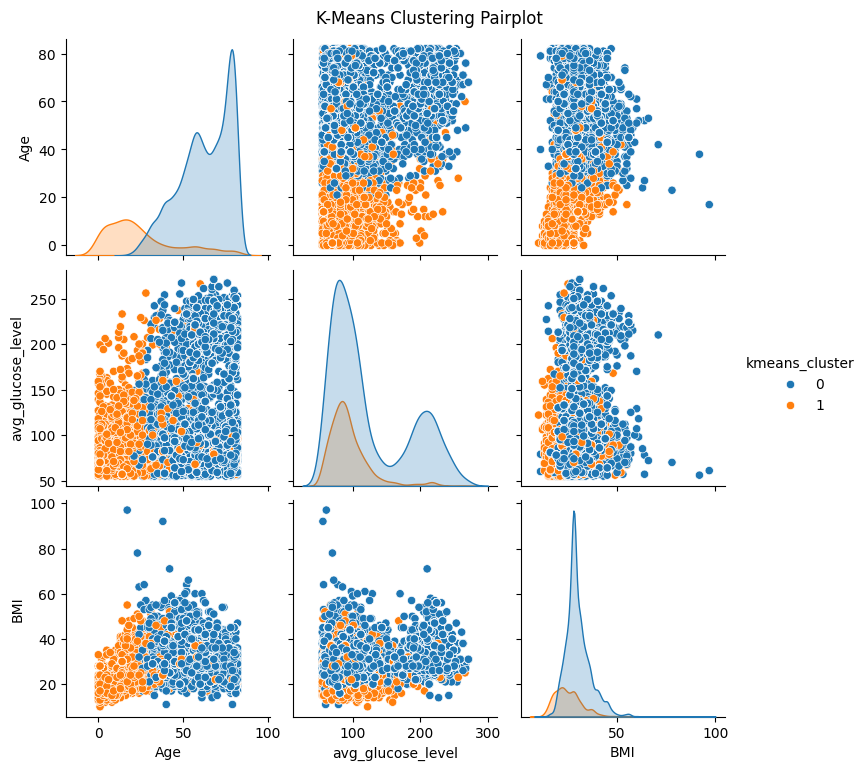

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'kmeans_predictions' is your Spark DataFrame with the full data
# First, select the necessary features and convert to Pandas DataFrame
feature_columns = ['Age', 'avg_glucose_level', 'BMI']
kmeanss_df = kmeans_predictions.select(feature_columns + ["kmeans_cluster"]).toPandas()

# Create a pairplot for the selected features, colored by K-Means cluster
sns.pairplot(kmeanss_df, hue='kmeans_cluster', diag_kind='kde', palette='tab10')
plt.suptitle('K-Means Clustering Pairplot', y=1.02)
plt.show()


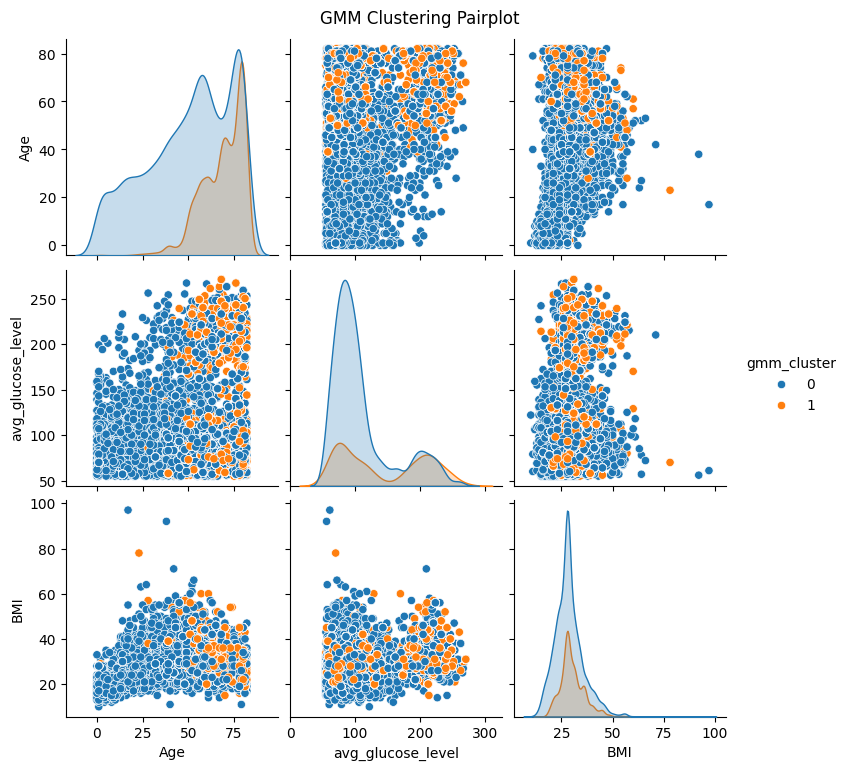

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'kmeans_predictions' is your Spark DataFrame with the full data
# First, select the necessary features and convert to Pandas DataFrame
feature_columns = ['Age', 'avg_glucose_level', 'BMI']
gmms_df = gmm_predictions.select(feature_columns + ["gmm_cluster"]).toPandas()

# Create a pairplot for the selected features, colored by K-Means cluster
sns.pairplot(gmms_df, hue='gmm_cluster', diag_kind='kde', palette='tab10')
plt.suptitle('GMM Clustering Pairplot', y=1.02)
plt.show()


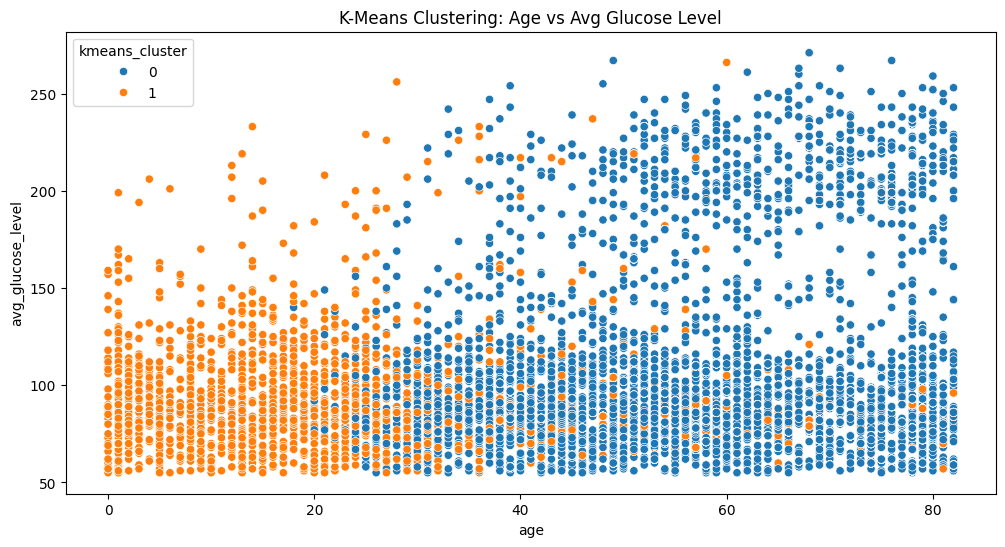

In [ ]:
# Scatterplot for K-Means
plt.figure(figsize=(12, 6))
sns.scatterplot(data=kmeans_df, x='age', y='avg_glucose_level', hue='kmeans_cluster', palette='tab10')
plt.title('K-Means Clustering: Age vs Avg Glucose Level')
plt.show()



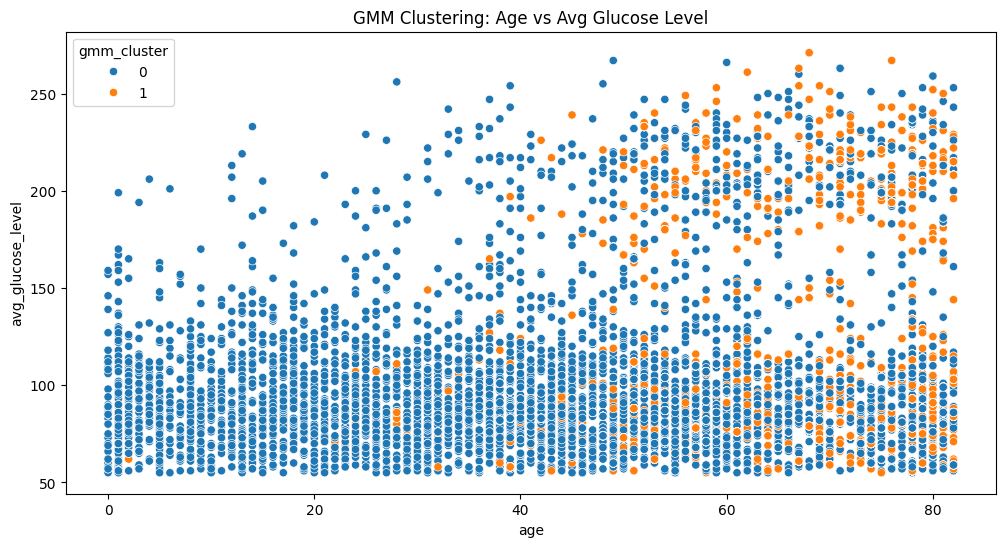

In [ ]:
# Scatterplot for GMM
plt.figure(figsize=(12, 6))
sns.scatterplot(data=gmm_df, x='age', y='avg_glucose_level', hue='gmm_cluster', palette='tab10')
plt.title('GMM Clustering: Age vs Avg Glucose Level')
plt.show()



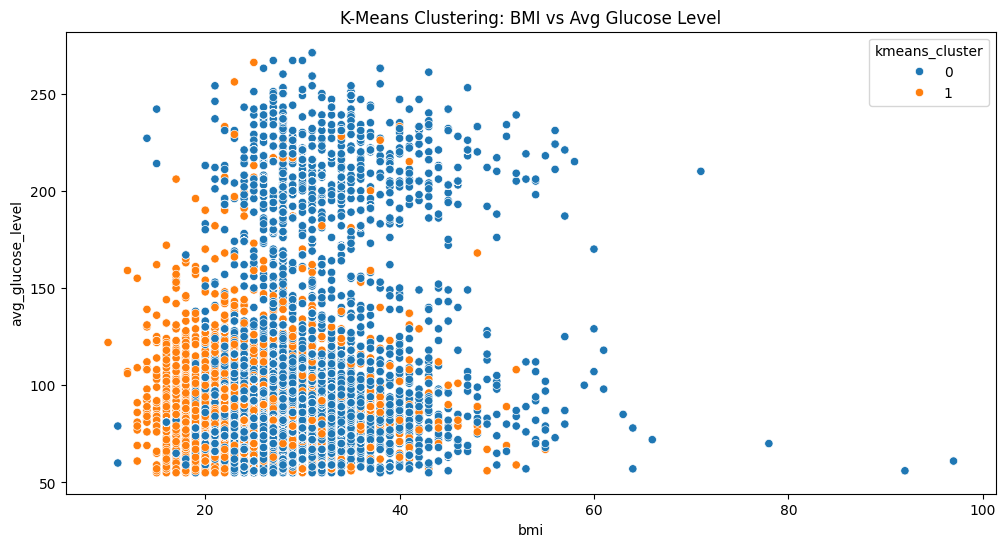

In [ ]:
# Scatterplot for K-Means (BMI vs Avg Glucose Level)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=kmeans_df, x='bmi', y='avg_glucose_level', hue='kmeans_cluster', palette='tab10')
plt.title('K-Means Clustering: BMI vs Avg Glucose Level')
plt.show()



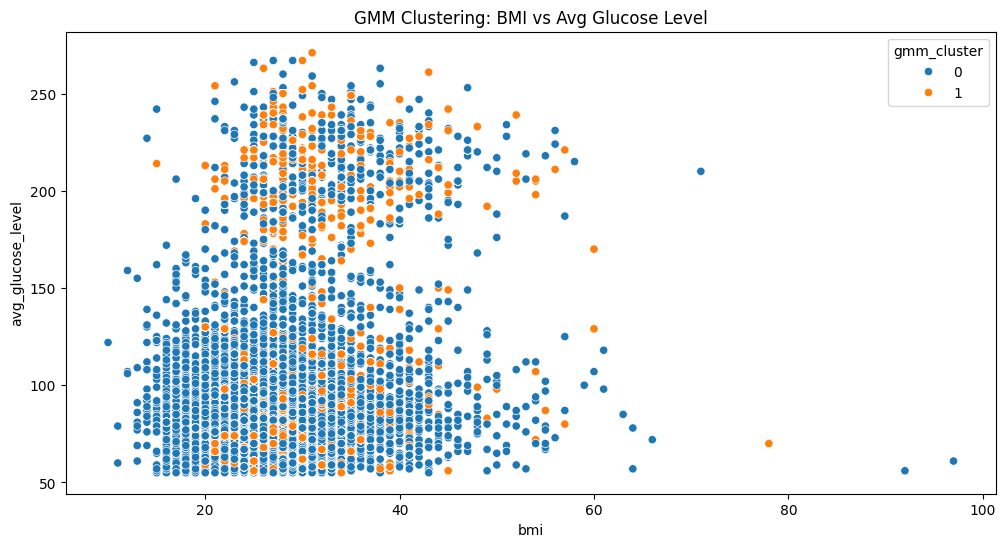

In [ ]:
# Scatterplot for GMM (BMI vs Avg Glucose Level)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=gmm_df, x='bmi', y='avg_glucose_level', hue='gmm_cluster', palette='tab10')
plt.title('GMM Clustering: BMI vs Avg Glucose Level')
plt.show()

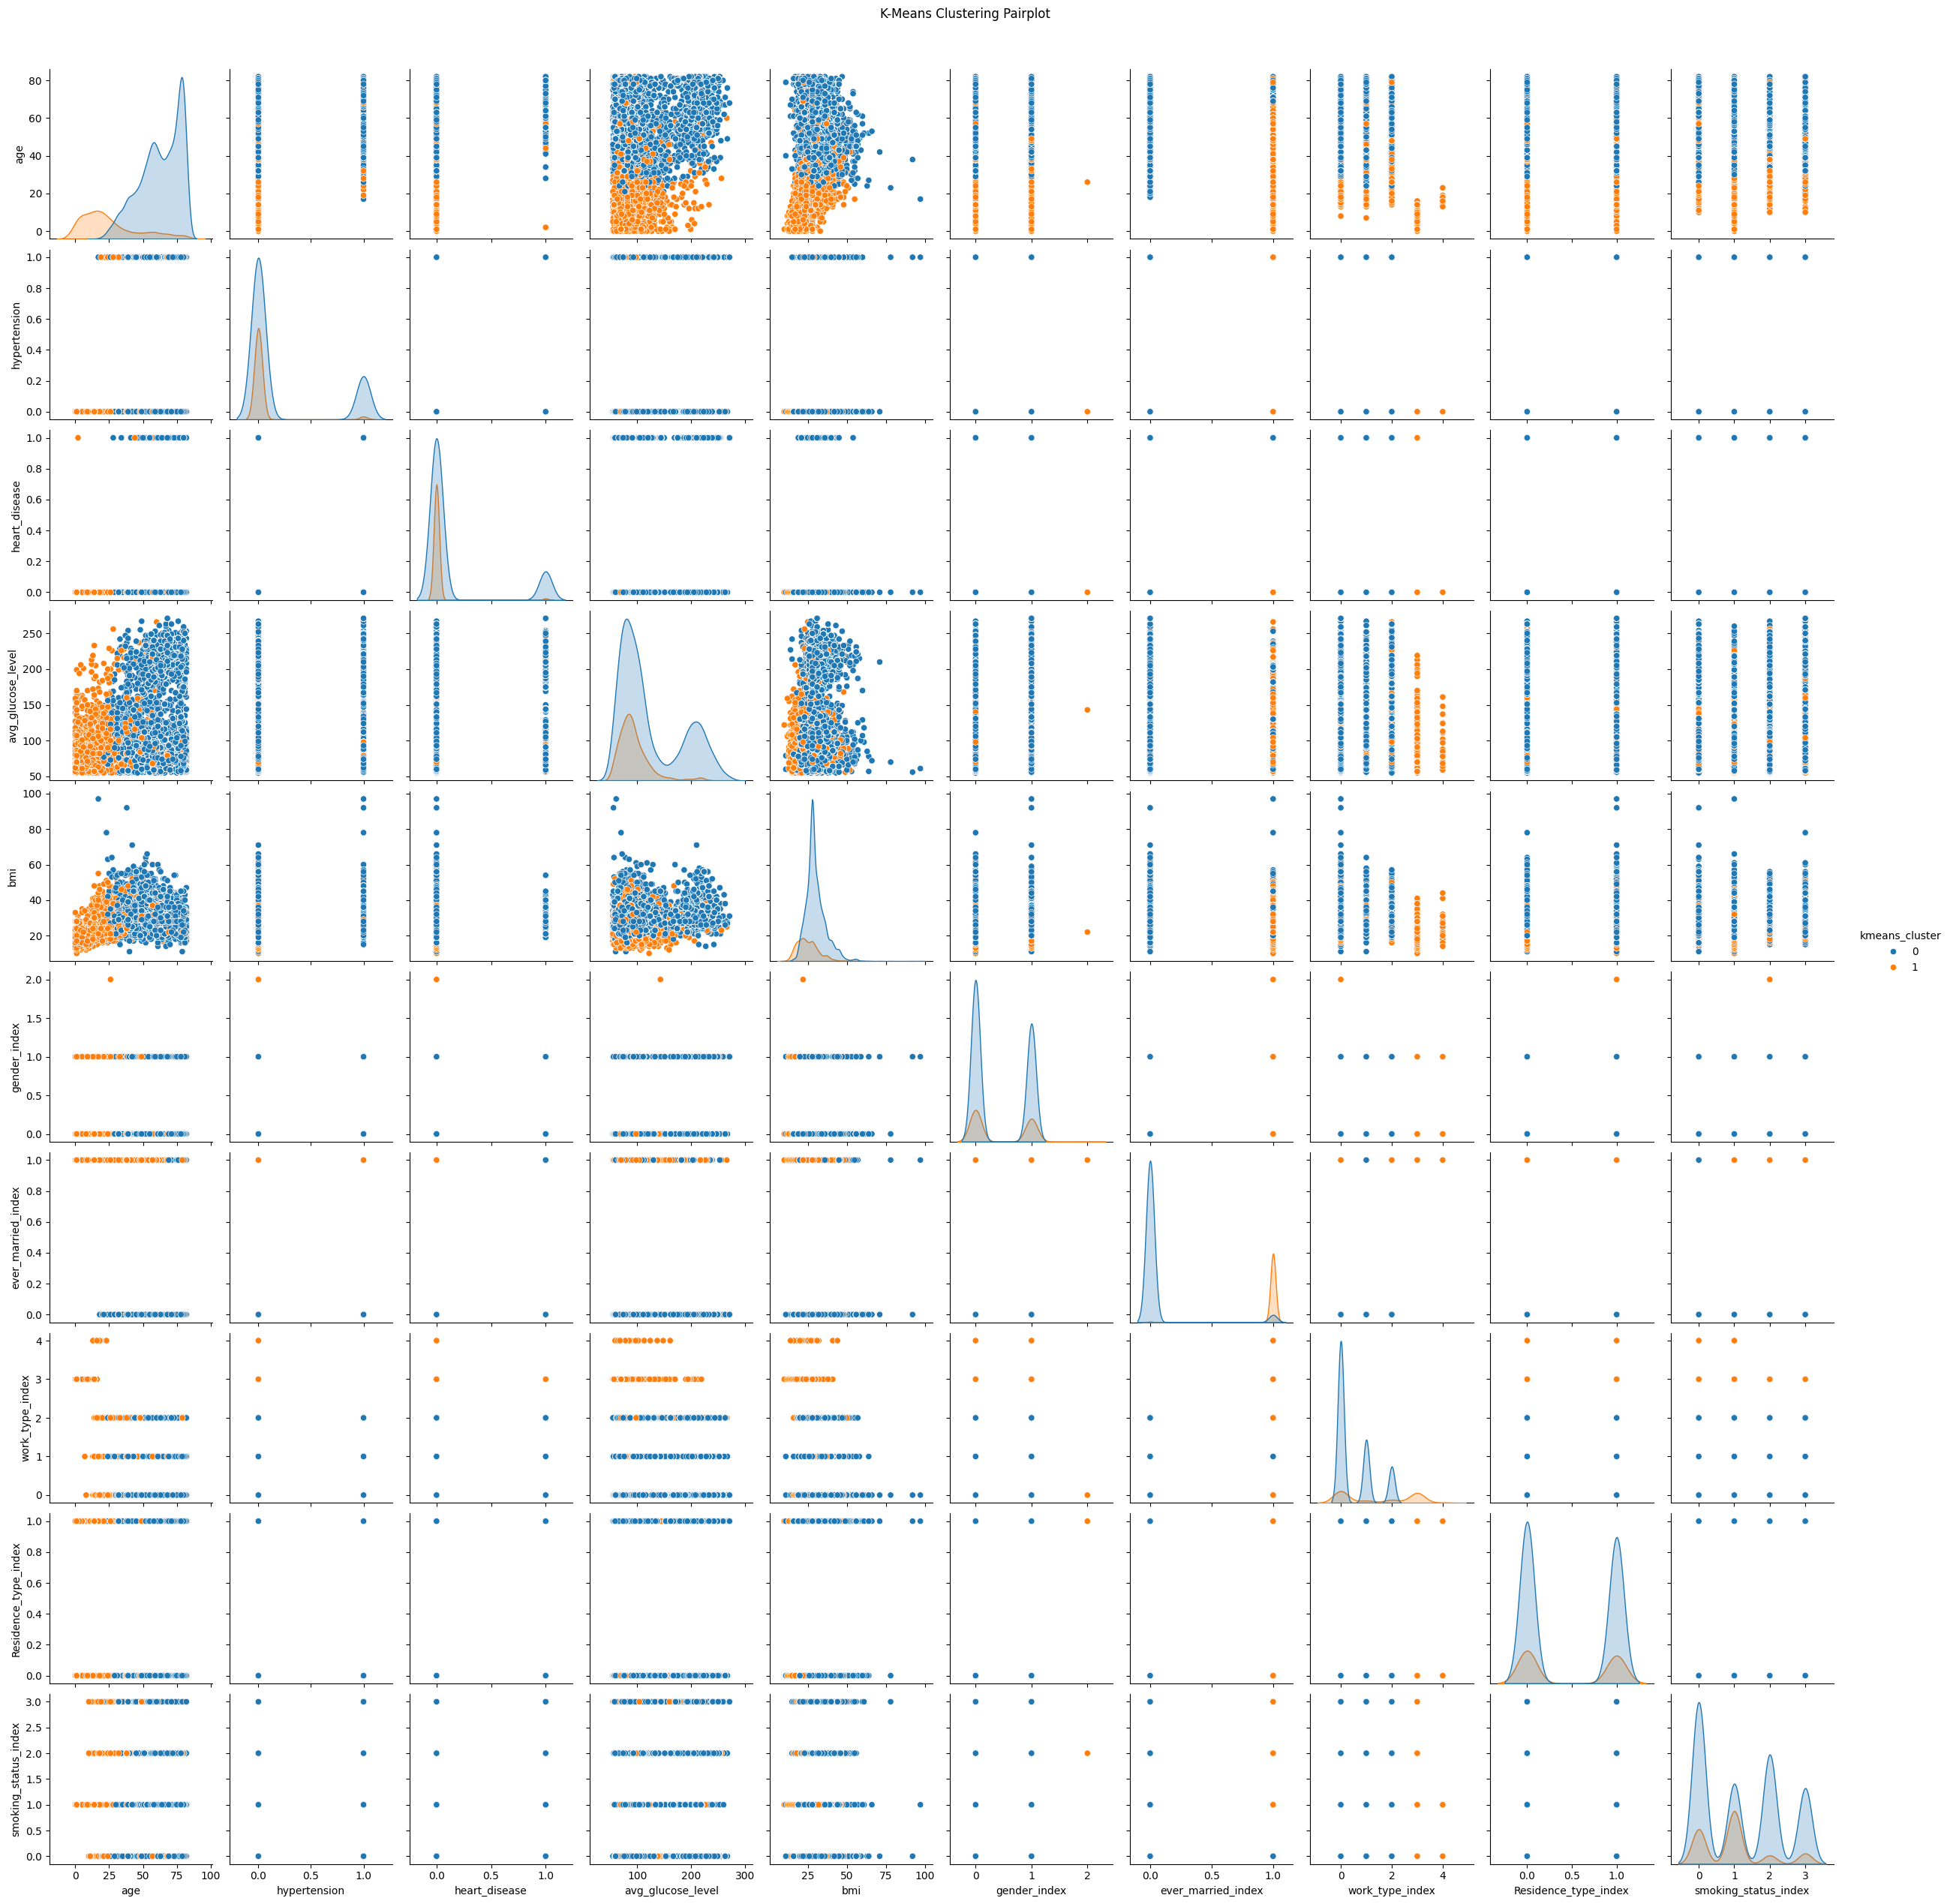

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pairplot for K-Means
sns.pairplot(kmeans_df, hue='kmeans_cluster', diag_kind='kde', palette='tab10')
plt.suptitle('K-Means Clustering Pairplot', y=1.02)
plt.show()


